###  Lenet-5 For MNIST hand written digit dataset

<hr>

#### Challenge - Build a DNN Model for MNIST Dataset Provided below. Expected Test accuracy is 97 %. The model build should have the number of Neural Network parameters smaller than 1 Lakh

Data Set URL - https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

<hr>


In [1]:
import os

import numpy as np                                           # For Feature scalling , Accuracy Calculation, Confusion_matrix
import pandas as pd                                          # For Loading Datset  
import matplotlib.pyplot as plt                              # For Image Visulization

import tensorflow as tf
from tensorflow.keras import Sequential                              # Sequential Api Has been used for Building Model
from tensorflow.keras.layers import Reshape,MaxPooling2D,Flatten     # For Model Layers
from tensorflow.keras.layers import BatchNormalization,Conv2D,Dense  # For Model Layers
from tensorflow.keras.initializers import HeNormal, GlorotNormal     # For Layers Weight initialization
from tensorflow.keras.optimizers import Adam                         # For Grediant Descent Optimization.
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model

print(tf.__version__)

2.10.0


#### Settingup Dataset Path

In [2]:
dataset_dir = os.path.join(".", 'data')                      #Dataset Directory Path

training_file = os.path.join(dataset_dir, 'mnist_train.csv') #Training Dataset Path
testing_file = os.path.join(dataset_dir, 'mnist_test.csv')   #Test Dataset Path 

if os.path.isfile(training_file) is False:                   #Validating the Training dataset Path
    raise FileNotFoundError(f'training file {training_file} not Valid')

if os.path.isfile(testing_file) is False:                    #Validating the Test dataset Path
    raise FileNotFoundError(f'testing file {testing_file} not Valid')

print(f'Traing and test file found on path {dataset_dir}')

Traing and test file found on path .\data


#### Loading Taring and Testing Dataset

In [3]:
training_df = pd.read_csv(training_file)

traindata_size, train_feature = training_df.shape

print(f'Training Dataset Shape {traindata_size} X {train_feature}')

test_df = pd.read_csv(testing_file)

testdata_size, test_feature = test_df.shape

print(f'Test Dataset Shape {testdata_size} X {test_feature}')

Training Dataset Shape 60000 X 785
Test Dataset Shape 10000 X 785


#### Training and Test datasets target values counts

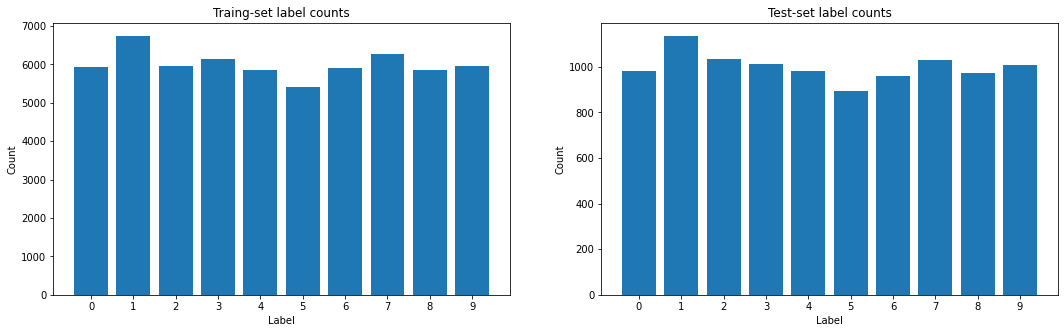

In [4]:
fig, (axs1, axs2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

label_counts1 = training_df['label'].value_counts().sort_index().to_dict()
axs1.bar(label_counts1.keys(), label_counts1.values())
axs1.set_xlabel('Label')
axs1.xaxis.set_ticks(list(label_counts1.keys()))
axs1.set_title('Traing-set label counts')
axs1.set_ylabel('Count')


label_counts2 = test_df['label'].value_counts().sort_index().to_dict()
axs2.bar(label_counts2.keys(), label_counts2.values())
axs2.set_xlabel('Label')
axs2.xaxis.set_ticks(list(label_counts2.keys()))
axs2.set_title('Test-set label counts')
axs2.set_ylabel('Count')

del label_counts1, label_counts2, fig, axs1, axs2
#del test_df

#### Dataset Visulization

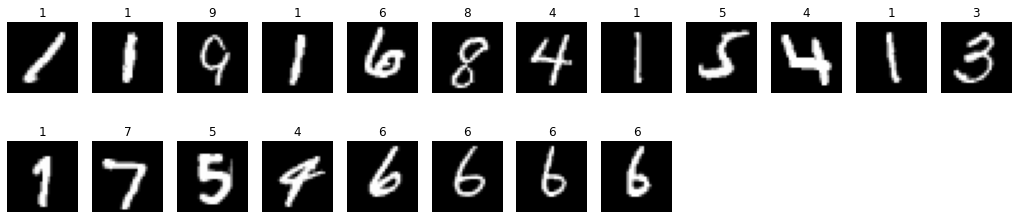

In [5]:
def dispaly_images(sample, ncols = 12):
    count,_ = sample.shape                   # Total Number image to plot
    nrows,x = divmod(count,ncols)            # Number of rows needed with with column = ncols, 
    nrows = nrows if x == 0 else nrows +1    # such that nrows x ncols >= count 
    fig = plt.figure(figsize = (18, 2*nrows))  # Creating grid type figure to house ncols times nrows images
    for s in range(0,count):
        lbl,img = sample[s,:][0],sample[s,:][1:] # Spliting each row of sample into target and image data 
        fig.add_subplot(nrows, ncols, s+1)       
        plt.imshow(img.reshape(28,28), cmap=plt.get_cmap('gray'))  # Resizing image data into 28X28 image 
        plt.axis('off')
        plt.title(lbl)
    plt.show()

dispaly_images( training_df.sample(20).values)        

####  Feature Scalling

In [6]:
train_x, train_y = training_df.values[:, 1:], training_df.values[:, 0]
test_x, test_y = test_df.values[:, 1:], test_df.values[:, 0]

# Minmax Normalization X= (x-Xmin)/(Xmax-xmin) Xmax=255, Xmin=0
train_x = train_x/255
# Minmax Normalization X= (x-Xmin)/(Xmax-xmin) Xmax=255, Xmin=0
test_x = test_x/255

print(f'train_x shape {train_x.shape}, train_y shape {train_y.shape}')
print(f'train_x shape {test_x.shape}, test_y shape {test_y.shape}')

train_x shape (60000, 784), train_y shape (60000,)
train_x shape (10000, 784), test_y shape (10000,)


#### Building Model with Keras Layers

In [7]:
def build_model():
    model = Sequential()
    model.add(Reshape((28, 28,1), input_shape=(784,)))      # input Shape (28,28,1)
    model.add(Conv2D(6, 5, activation='relu'))              # output size 6 X (28-5+1) X (28-5+1) = 6 X 24 X 24
    model.add(MaxPooling2D(pool_size=(2, 2) ))              # output size 6 X (24/2) X (24/2) = 6 X 12 X 12
    model.add(Conv2D(16, 5, activation='relu'))             # output size 16 X (12-5+1) X (12-5+1) = 16 X 8 X 8         
    model.add(MaxPooling2D(pool_size=(2, 2) ))              # output size 16 X (8/2) X (8/2) = 16 X 4 X 4
    model.add(Flatten())                                    # output size 256
    model.add(Dense(120,activation='relu'))                 # output size 120
    model.add(Dense(84,activation='relu'))                  # output size 84 
    model.add(Dense(10,activation='softmax'))               # output size 10
    return model          

def build_final_model():
    model = Sequential()
    model.add(Reshape((28, 28,1), input_shape=(784,)))      # input Shape (28,28,1)
    model.add(Conv2D(6, 5, activation='tanh',
                     kernel_initializer=GlorotNormal()))    # output size 6 X (28-5+1) X (28-5+1) = 6 X 24 X 24
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2) ))              # output size 6 X (24/2) X (24/2) = 6 X 12 X 12
    model.add(Conv2D(16, 5, activation='tanh',
                    kernel_initializer=GlorotNormal()))     # output size 16 X (12-5+1) X (12-5+1) = 16 X 8 X 8         
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2) ))              # output size 16 X (8/2) X (8/2) = 16 X 4 X 4
    model.add(Flatten())                                    # output size 256
    model.add(Dense(120,activation='tanh',
                   kernel_initializer=GlorotNormal()))      # output size 120
    model.add(BatchNormalization())
    model.add(Dense(84,activation='tanh',
                   kernel_initializer=GlorotNormal()))      # output size 84 
    model.add(Dense(10,activation='softmax'))               # output size 10
    return model          

In [8]:
model = build_final_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 16)         6

## We can see from the Model summary ,Total number  parameter count is  44,994 which less than 1 Lakh

#### Setting up model optimizer and loss and callbacks For Training Loop

In [9]:
# model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

saved_model_path = os.path.join('.','model','coding_challenge_model.h5')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(saved_model_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy']
             )

history = model.fit(train_x, 
                    train_y, 
                    epochs=30,
                    validation_split=0.2, 
                    batch_size=64,
                    callbacks=[es,mc]
                   )

Epoch 1/30
750/750 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.9202
Epoch 1: val_accuracy improved from -inf to 0.96633, saving model to .\model\coding_challenge_model.h5
750/750 [==============================] - 13s 14ms/step - loss: 0.2729 - accuracy: 0.9202 - val_loss: 0.1137 - val_accuracy: 0.9663
Epoch 2/30
749/750 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9724
Epoch 2: val_accuracy improved from 0.96633 to 0.97367, saving model to .\model\coding_challenge_model.h5
750/750 [==============================] - 10s 13ms/step - loss: 0.0914 - accuracy: 0.9724 - val_loss: 0.0830 - val_accuracy: 0.9737
Epoch 3/30
750/750 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9815
Epoch 3: val_accuracy improved from 0.97367 to 0.97858, saving model to .\model\coding_challenge_model.h5
750/750 [==============================] - 10s 13ms/step - loss: 0.0608 - accuracy: 0.9815 - val_loss: 0.0709 - val_accuracy: 0.978

748/750 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9982
Epoch 28: val_accuracy did not improve from 0.98767
750/750 [==============================] - 10s 13ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0682 - val_accuracy: 0.9852
Epoch 29/30
746/750 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9983
Epoch 29: val_accuracy did not improve from 0.98767
750/750 [==============================] - 10s 13ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0775 - val_accuracy: 0.9831
Epoch 29: early stopping


#### Loss & Accuracy visualization  

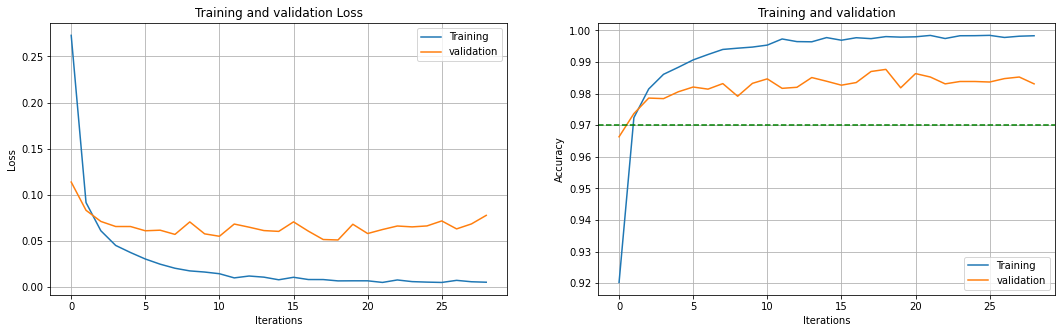

In [10]:
def plot_model_training(data):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
    ax1.plot(data.history['loss'], label="Training")
    ax1.plot(data.history['val_loss'], label="validation")
    ax1.set_title('Training and validation Loss')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(data.history['accuracy'], label="Training")
    ax2.plot(data.history['val_accuracy'], label="validation")
    ax2.axhline(y=0.97, color='g', linestyle='--')
    ax2.set_title('Training and validation')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend(loc="lower right")
    plt.show()


plot_model_training(history)

#### Model Evaluation on Test dataset

In [11]:
trained_model = load_model(saved_model_path)
score = trained_model.evaluate(test_x, test_y, verbose=0)

print(f'Test loss {score[0]}')
print(f'Test accuracy {score[1]}')
print(score)

Test loss 0.052936431020498276
Test accuracy 0.9865999817848206
[0.052936431020498276, 0.9865999817848206]


## Accuracy achieved on Test Dataset is 98.6%

In [12]:
y_prob = trained_model.predict(test_x)
y_pred = y_prob.argmax(axis=1)

print(f'y_pred Shape {y_pred.shape}')

313/313 [==============================] - 1s 3ms/step
y_pred Shape (10000,)


#### Accuracy score calculations [ Manually Recalculating Accuracy using numpy ] 

In [13]:
true_pred = np.sum(np.equal(test_y, y_pred))
total_observation = 10000
accuracy = true_pred / total_observation
print(accuracy)

0.9866


## Accuracy achieved on Test Dataset is 98.6%

#### Calculating Confusion Matrix 

In [14]:
from itertools import product  # For calculation of confusion Matrix


def build_confusion_matrix(y_true, y_predict):
    class_lbl = np.unique(np.concatenate((y_true, y_predict)))  # Collecting Unique Class labels
    n_lbl = class_lbl.shape[0]                                  # Counting Unique Class labels   
    temp = list(zip(y_true, y_predict))                         # Zipping Y-true and Y-pred
    confu_mat = []                                              
    for combinations  in product(class_lbl,repeat=2):          # Iterating over all Possible combinations class label ; NC2 
        confu_mat.append(temp.count(combinations))             # Couting the combination on ziped list       
    return np.asarray(confu_mat).reshape(n_lbl,n_lbl)          # Reshapping the array Matrix

mat = build_confusion_matrix(test_y, y_pred)    
print(mat)

[[ 972    0    0    0    0    0    4    2    2    0]
 [   0 1127    1    1    0    1    2    1    1    1]
 [   1    2 1022    0    0    0    0    4    3    0]
 [   0    0    3  993    0    8    0    2    1    3]
 [   0    0    0    0  970    0    3    0    0    9]
 [   2    0    0    5    0  881    2    0    1    1]
 [   3    2    1    1    2    1  946    0    2    0]
 [   1    7    5    2    0    1    0 1008    1    3]
 [   3    0    2    1    0    1    0    2  964    1]
 [   2    2    0    4    8    3    0    3    4  983]]


#### Plotting the Confusion Matrix

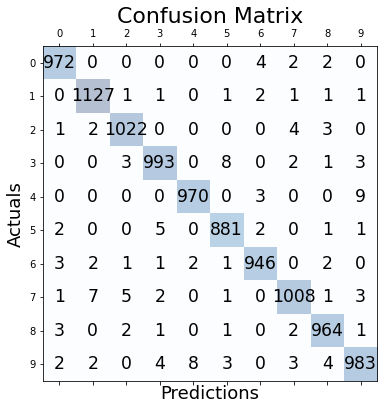

In [15]:
def plot_confusion_matix(confusion_matix):
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.matshow(confusion_matix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_matix.shape[0]):
        for j in range(confusion_matix.shape[1]):
            ax.text(x=j, y=i, s=confusion_matix[i, j],
                    va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    ax.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.yaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.title('Confusion Matrix', fontsize=22)
    plt.show()


plot_confusion_matix(mat)

#### Neagtive Prediction visualization

(134, 785)


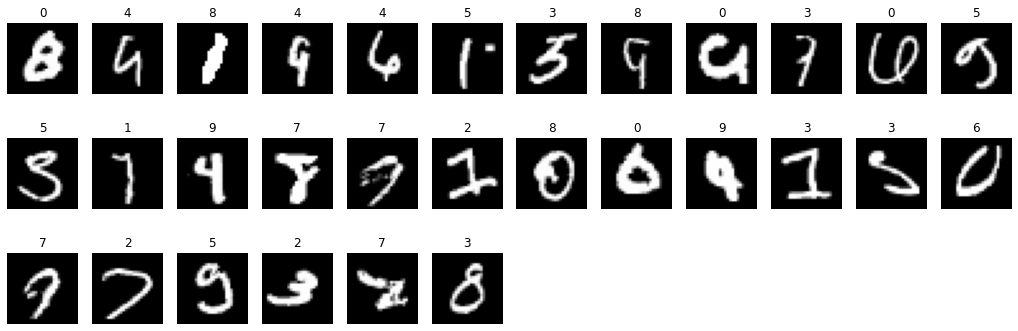

In [16]:
# Creating a new Column in test Dataframe with Predicted output
test_df['prediction'] = y_pred

test_df['FP_FN'] = test_df.apply(    # Creating Another Column For FP and FN indicators
    lambda row: 1 if row['label'] != row['prediction'] else 0,
    axis=1)

# Selecting all the False Prediction in a sample dataframe
sample_fp_fn = test_df[test_df['FP_FN'] == 1].copy()

# Replaceing the True Labels with Predicted Values for disply
sample_fp_fn['label'] = sample_fp_fn.apply(
    lambda row: row['prediction'], axis=1)

# Dropping the 'prediction', 'FP_FN' Columns
sample_fp_fn.drop(columns=['prediction', 'FP_FN'], inplace=True)

print(sample_fp_fn.shape)

# Finally Displaying only Flase Predictions
dispaly_images(sample_fp_fn.sample(30).values)